This material is prepared as partial fulfilment of the <br> Course: **Introduction to Data Science and Machine Learning for Geo-spatial Data** <br> and could be reused for the <br> Course:**Earth observation and spatial data science for the social good** <br>
<br> Theme of the material:**Time series analysis for hurricane prediction using LSTMs** <br>
Prepared by: *Getachew Workineh Gella* <br>
Paris Lodron University of Salzburg (PLUS), Department of Applied Geoinformatics<br>
email: getachewworkineh.gella@plus.ac.at

**Note!:** *Some commented cells are optional based on availability of data and implemntation strategy*
#### Loading Necessary packages for data reading, exploration and sequence modeling

In [155]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [156]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import seaborn as sbn
import matplotlib.pyplot as plt
import datetime
import random
from sklearn import preprocessing
from sklearn.model_selection import train_test_split  # if sample split is not done by user defined code
from tensorflow.keras.layers import Input, LSTM, Dropout, Bidirectional, BatchNormalization, Dense
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

#### Read the data
It should be noted that while reading the data using pandas dataframe approach, it is possible to manage nodata values on the flight or remove it after reading the data
For this excercise I have opted to tell the datafram reader to consider -999 as No data value

In [157]:
path = '/content/drive/MyDrive/plus-deepdata-social-good-master/atlantic.csv'
PD = pd.read_csv(path, na_values=-999)   # -999

#### Inspect the attribute names(column names) and respective data types.
This will enable enable to select proper data conversion options in further processing steps.
It shoud be noted that in pandas dataframe string objects are considered as object data types

In [158]:
print('The number of attributes in the dataset is : {}'.format(len(list(PD.keys()))))
col_names = list(PD.keys())
print('Attribute -> data type')
for name in col_names:
    print('{} -> {}'.format(name, PD[name].dtype))

The number of attributes in the dataset is : 22
Attribute -> data type
ID -> object
Name -> object
Date -> int64
Time -> int64
Event -> object
Status -> object
Latitude -> object
Longitude -> object
Maximum Wind -> int64
Minimum Pressure -> float64
Low Wind NE -> float64
Low Wind SE -> float64
Low Wind SW -> float64
Low Wind NW -> float64
Moderate Wind NE -> float64
Moderate Wind SE -> float64
Moderate Wind SW -> float64
Moderate Wind NW -> float64
High Wind NE -> float64
High Wind SE -> float64
High Wind SW -> float64
High Wind NW -> float64


### Inspect the first five and the last five rows with full columns.
<div style="text-align: justify"> This gives overll picture of data. As can be seen from the table displayed below, the first few rows
are dominated by incomplete observations except for latitude, longitue of the herican cenetrs. As can be seen from Herican Unique ID and Unique name count, names are less than Unique IDS. This is mainly
because of repeatedly happening herricaens happening at some geographies were given the same names but different ids and some hericanes were given a name of UnKnown.Therefore, as every trajectory monitoring is based on tagged unique herican name, in the feature engineering/preparation section, unique IDS will use to organize the data.   </div>


In [159]:
PD.head()

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
0,AL011851,UNNAMED,18510625,0,,HU,28.0N,94.8W,80,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AL011851,UNNAMED,18510625,600,,HU,28.0N,95.4W,80,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AL011851,UNNAMED,18510625,1200,,HU,28.0N,96.0W,80,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AL011851,UNNAMED,18510625,1800,,HU,28.1N,96.5W,80,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AL011851,UNNAMED,18510625,2100,L,HU,28.2N,96.8W,80,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [160]:
# inspect the data structure of the last five rows with all columns
PD.tail()

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
49100,AL122015,KATE,20151112,1200,,EX,41.3N,50.4W,55,981.0,...,180.0,120.0,120.0,120.0,60.0,0.0,0.0,0.0,0.0,0.0
49101,AL122015,KATE,20151112,1800,,EX,41.9N,49.9W,55,983.0,...,180.0,120.0,120.0,120.0,60.0,0.0,0.0,0.0,0.0,0.0
49102,AL122015,KATE,20151113,0,,EX,41.5N,49.2W,50,985.0,...,200.0,220.0,120.0,120.0,60.0,0.0,0.0,0.0,0.0,0.0
49103,AL122015,KATE,20151113,600,,EX,40.8N,47.5W,45,985.0,...,180.0,220.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49104,AL122015,KATE,20151113,1200,,EX,40.7N,45.4W,45,987.0,...,150.0,220.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [161]:
# count names and IDS of the hericanes
ids = np.unique(PD['ID'])
print('Number of total hurican unique IDS: {}'.format(len(ids)))
names = np.unique(PD['Name'])
print('Number of total hurican unique names: {}'.format(len(names)))

Number of total hurican unique IDS: 1814
Number of total hurican unique names: 288


### Data conversion and cleaning
<div style="text-align: justify"> As can be seen from the tables displayed the following observations were taken into consideration <br>
1. Observations with massive incomplete data which are conequetive(exclude from analysis) <br>
    2. Some rows whith some missing values were imputed with mean values of observations from the same herican. It should ne noted that, this should betaken with great caution as it will introduce extra noise to the data <br>
    3. Latitude and longitude values which are the main interest of this analysis were given as textual information whith hemispheric information(North/south, west/east).Using this information, the coordinates were converted to float longitude and latutidude. X coordinate in west and Y coordinate in south hemispher were converted to negative values. this gives a universal/uniform representation of coordinates <br>
    4. Date value is provided as string literal (YYMMDD) and then converted to Day of the Year (DOY) format <br>
    5. The Time value is converted from thousand notation to normal 24 hours scale which is more meaningfull </div>



In [162]:
def manage_long(df):
    '''
    Converts text longitude into numeric longitude
    the west is converted into negative values while the east is converted to positive values
    df: a data frame containing longitude value
    returns Longitude value with numeric representation without hemispheric information
    '''
    dff = df.copy()
    long = np.array(dff['Longitude'])

    for i in range(long.shape[0]):
        if "W" in long[i]:
            long[i] = float(long[i].replace('W',''))*-1
        elif 'E' in long[i]:
            long[i] = float(long[i].replace('E',''))*1
        else:
            raise ValueError('The value has no direction indicator')
    return long

In [163]:
def manage_lat(df):
    '''
    Converts text latitude into numeric latitude
    the South is converted into negative values while the North is converted to positive values
    df: a data frame containing Latitude value
    returns Latitude value with numeric representation without hemispheric information
    '''
    dff = df.copy()
    lat = np.array(dff['Latitude'])

    for i in range(lat.shape[0]):
        if "S" in lat[i]:
            lat[i] = float(lat[i].replace('S',''))*-1
        elif "N" in lat[i]:
            lat[i] = float(lat[i].replace('N',''))*1
        else:
            raise ValueError('The value has no direction indicator')
    return lat

#####  Remove a subset of the dataset which have not sufficient observations and check presence of na values
As can be seen from the cell output below, even after droping a subset of the dataset which have nodata value there are still 80 records with nodata value for some columns/attributes.

In [164]:
PD_n = PD.loc[43106:]
PD_n.isna().sum()

,0
ID,0
Name,0
Date,0
Time,0
Event,0
Status,0
Latitude,0
Longitude,0
Maximum Wind,0
Minimum Pressure,0


In [165]:
PD_n.head(n=7)

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
43106,AL012004,ALEX,20040801,600,,TD,31.5N,79.0W,25,1009.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43107,AL012004,ALEX,20040801,1200,,TD,31.6N,79.1W,30,1009.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43108,AL012004,ALEX,20040801,1800,,TS,31.6N,79.2W,35,1009.0,...,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43109,AL012004,ALEX,20040802,0,,TS,31.5N,79.3W,35,1007.0,...,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43110,AL012004,ALEX,20040802,600,,TS,31.4N,79.4W,40,1005.0,...,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43111,AL012004,ALEX,20040802,1200,,TS,31.3N,79.0W,50,992.0,...,60.0,20.0,30.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0
43112,AL012004,ALEX,20040802,1800,,TS,31.8N,78.7W,50,993.0,...,50.0,30.0,30.0,30.0,20.0,20.0,0.0,0.0,0.0,0.0


#### Convert latitude and longitude from hemispheric representation to numeric one
As noted above, if its West and south values were become negative coordinate values

In [166]:
PD_n['Latitude'] = manage_lat(PD_n)
PD_n['Longitude'] = manage_long(PD_n)
PD_n[["Latitude", "Longitude"]] = PD_n[["Latitude", "Longitude"]].apply(pd.to_numeric)
latlong = PD_n[["Latitude", "Longitude"]]
latlong.head()

,Latitude,Longitude
43106,31.5,-79.0
43107,31.6,-79.1
43108,31.6,-79.2
43109,31.5,-79.3
43110,31.4,-79.4


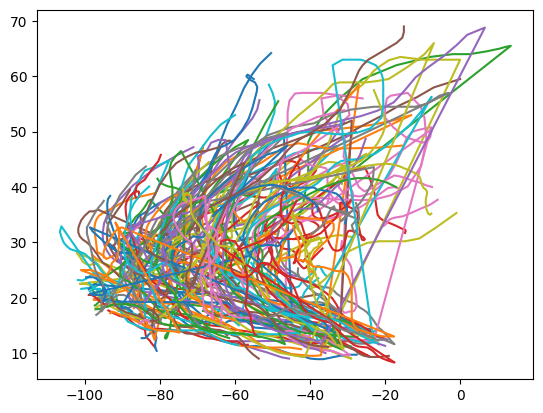

In [167]:
PD_n.head()
names = np.unique(PD_n['Name'])
for name in names:
    dfd = PD_n[PD_n['Name'] == name]
    plt.plot(dfd['Longitude'], dfd['Latitude'], label=name)
# plt.legend()
plt.show()

### Visualization and data inspection
Chceck the converted longitude and latutude values by ploting in a 2D cartesian space

###### Convert time into 24 hour scale and date into Day of The Year (DOY) format, and inspect the converted date

In [168]:
PD_n['Date'] = [datetime.datetime.strptime(str(PD_n['Date'].iloc[i]),'%Y%m%d').timetuple().tm_yday for i in range(PD_n.shape[0])]
PD_n['Time'] = PD_n['Time']/100   # convert time into proper 24 hourse scale
datetime = PD_n[["Date", "Time"]]
datetime.head()

,Date,Time
43106,214,6.0
43107,214,12.0
43108,214,18.0
43109,215,0.0
43110,215,6.0


##### Inspect if there is highly outocorrelating attribute in the dataframe
Please note that panda data frame correlation analysis ignores non-numeric columns from correlation computation. This selection of numeric values could also be done mannually. As indicated in the correlation matrix plot, the Minimim pressure and Maximum wind has negatively correlated. As this values are very important for hericane prediction and monitoring I would prefer to keep it.

In [100]:
# PD_n.keys()
# PD_n = PD_n.drop(columns=['Name', 'Event', 'Status']) # 'ID',

Remove nodata value and replace with means. here there is no hard rule how to replace no data vale

In [169]:
# replace Nans with column means per hericane based on herican ID
ids = list(np.unique(PD_n['ID']))
for i in range(len(ids)):
    sub = PD_n[PD_n['ID']==ids[i]]
    # if i == 0:
      # print(sub.head())
    sub=sub.fillna(sub.drop(columns=['Name', 'Event', 'Status','ID']).mean())
    PD_n[PD_n['ID']==ids[i]] = sub
PD_n.isna().sum()   # check the na removed dataframe


,0
ID,0
Name,0
Date,0
Time,0
Event,0
Status,0
Latitude,0
Longitude,0
Maximum Wind,0
Minimum Pressure,0


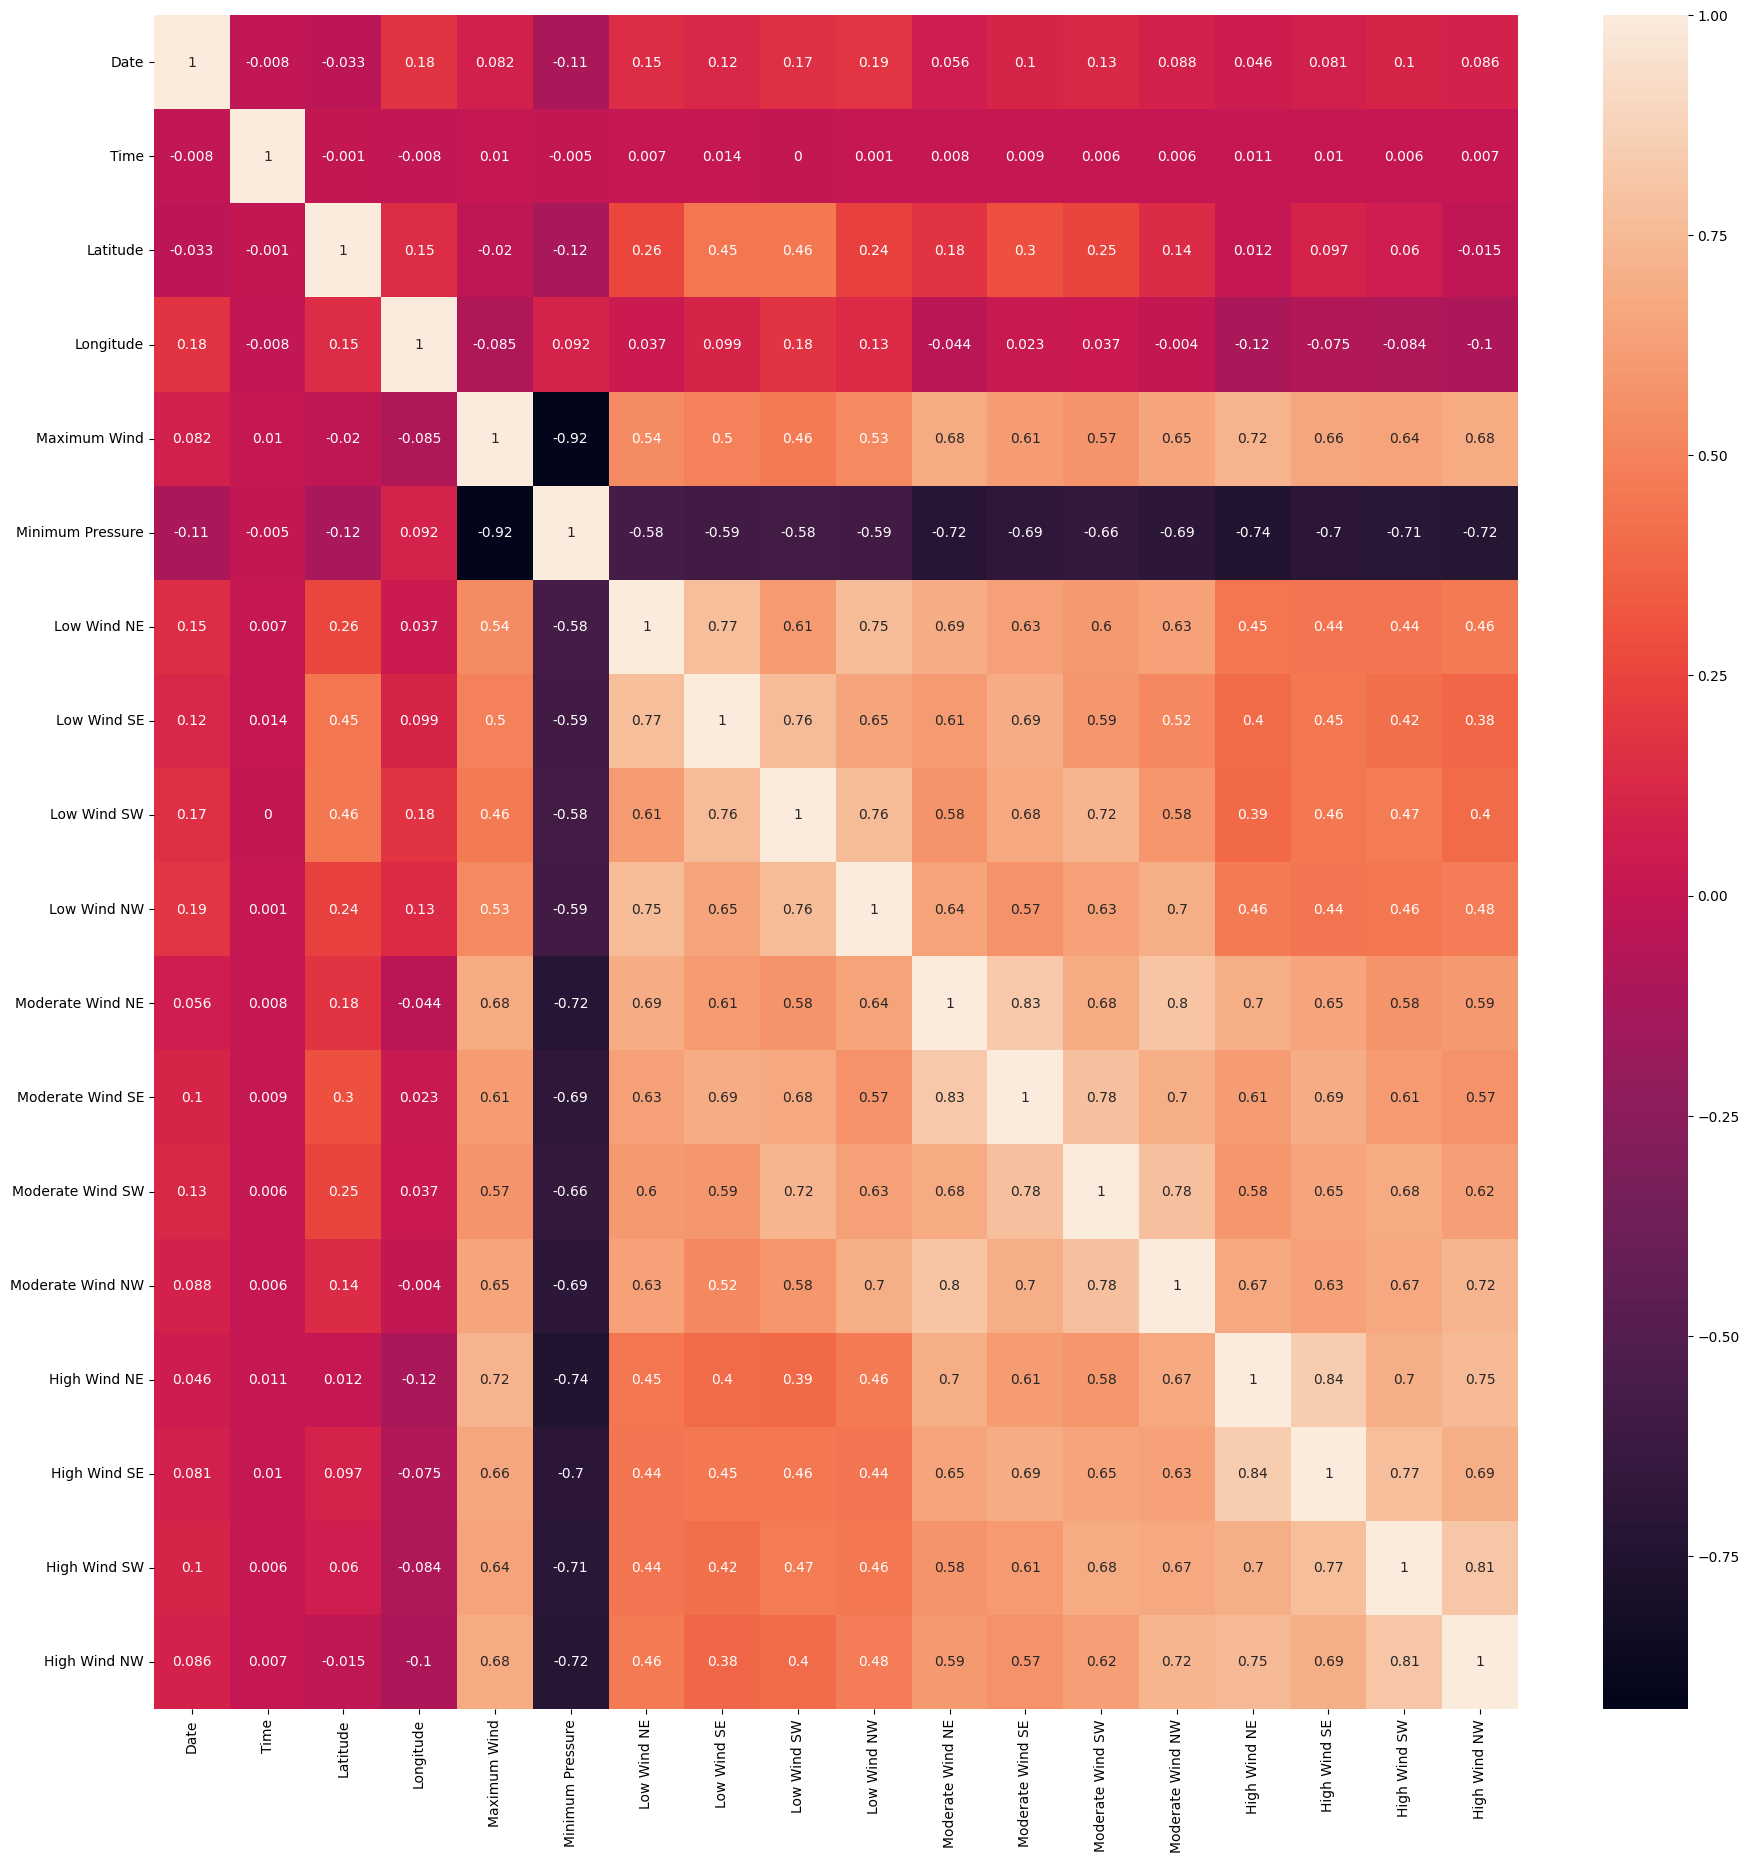

In [170]:
# PD_n_sub = PD_n.drop(columns=['ID'])
crmtx = round(PD_n.drop(columns=['Name', 'Event', 'Status', 'ID']).corr(), 3)
# print(crmtx) # possible to print but not aesthetically attractive
plt.figure(figsize=(22,22))
sbn.heatmap(crmtx, annot=True)
plt.show()

##### Inspect the histogram/frequency dstribution of each umeric fields
As can be seen from the histogram plots, most of the attributes related to wind speed are with left skwed(right tailed) distributions. Latitude Longitude and Time have almost normal distribition.

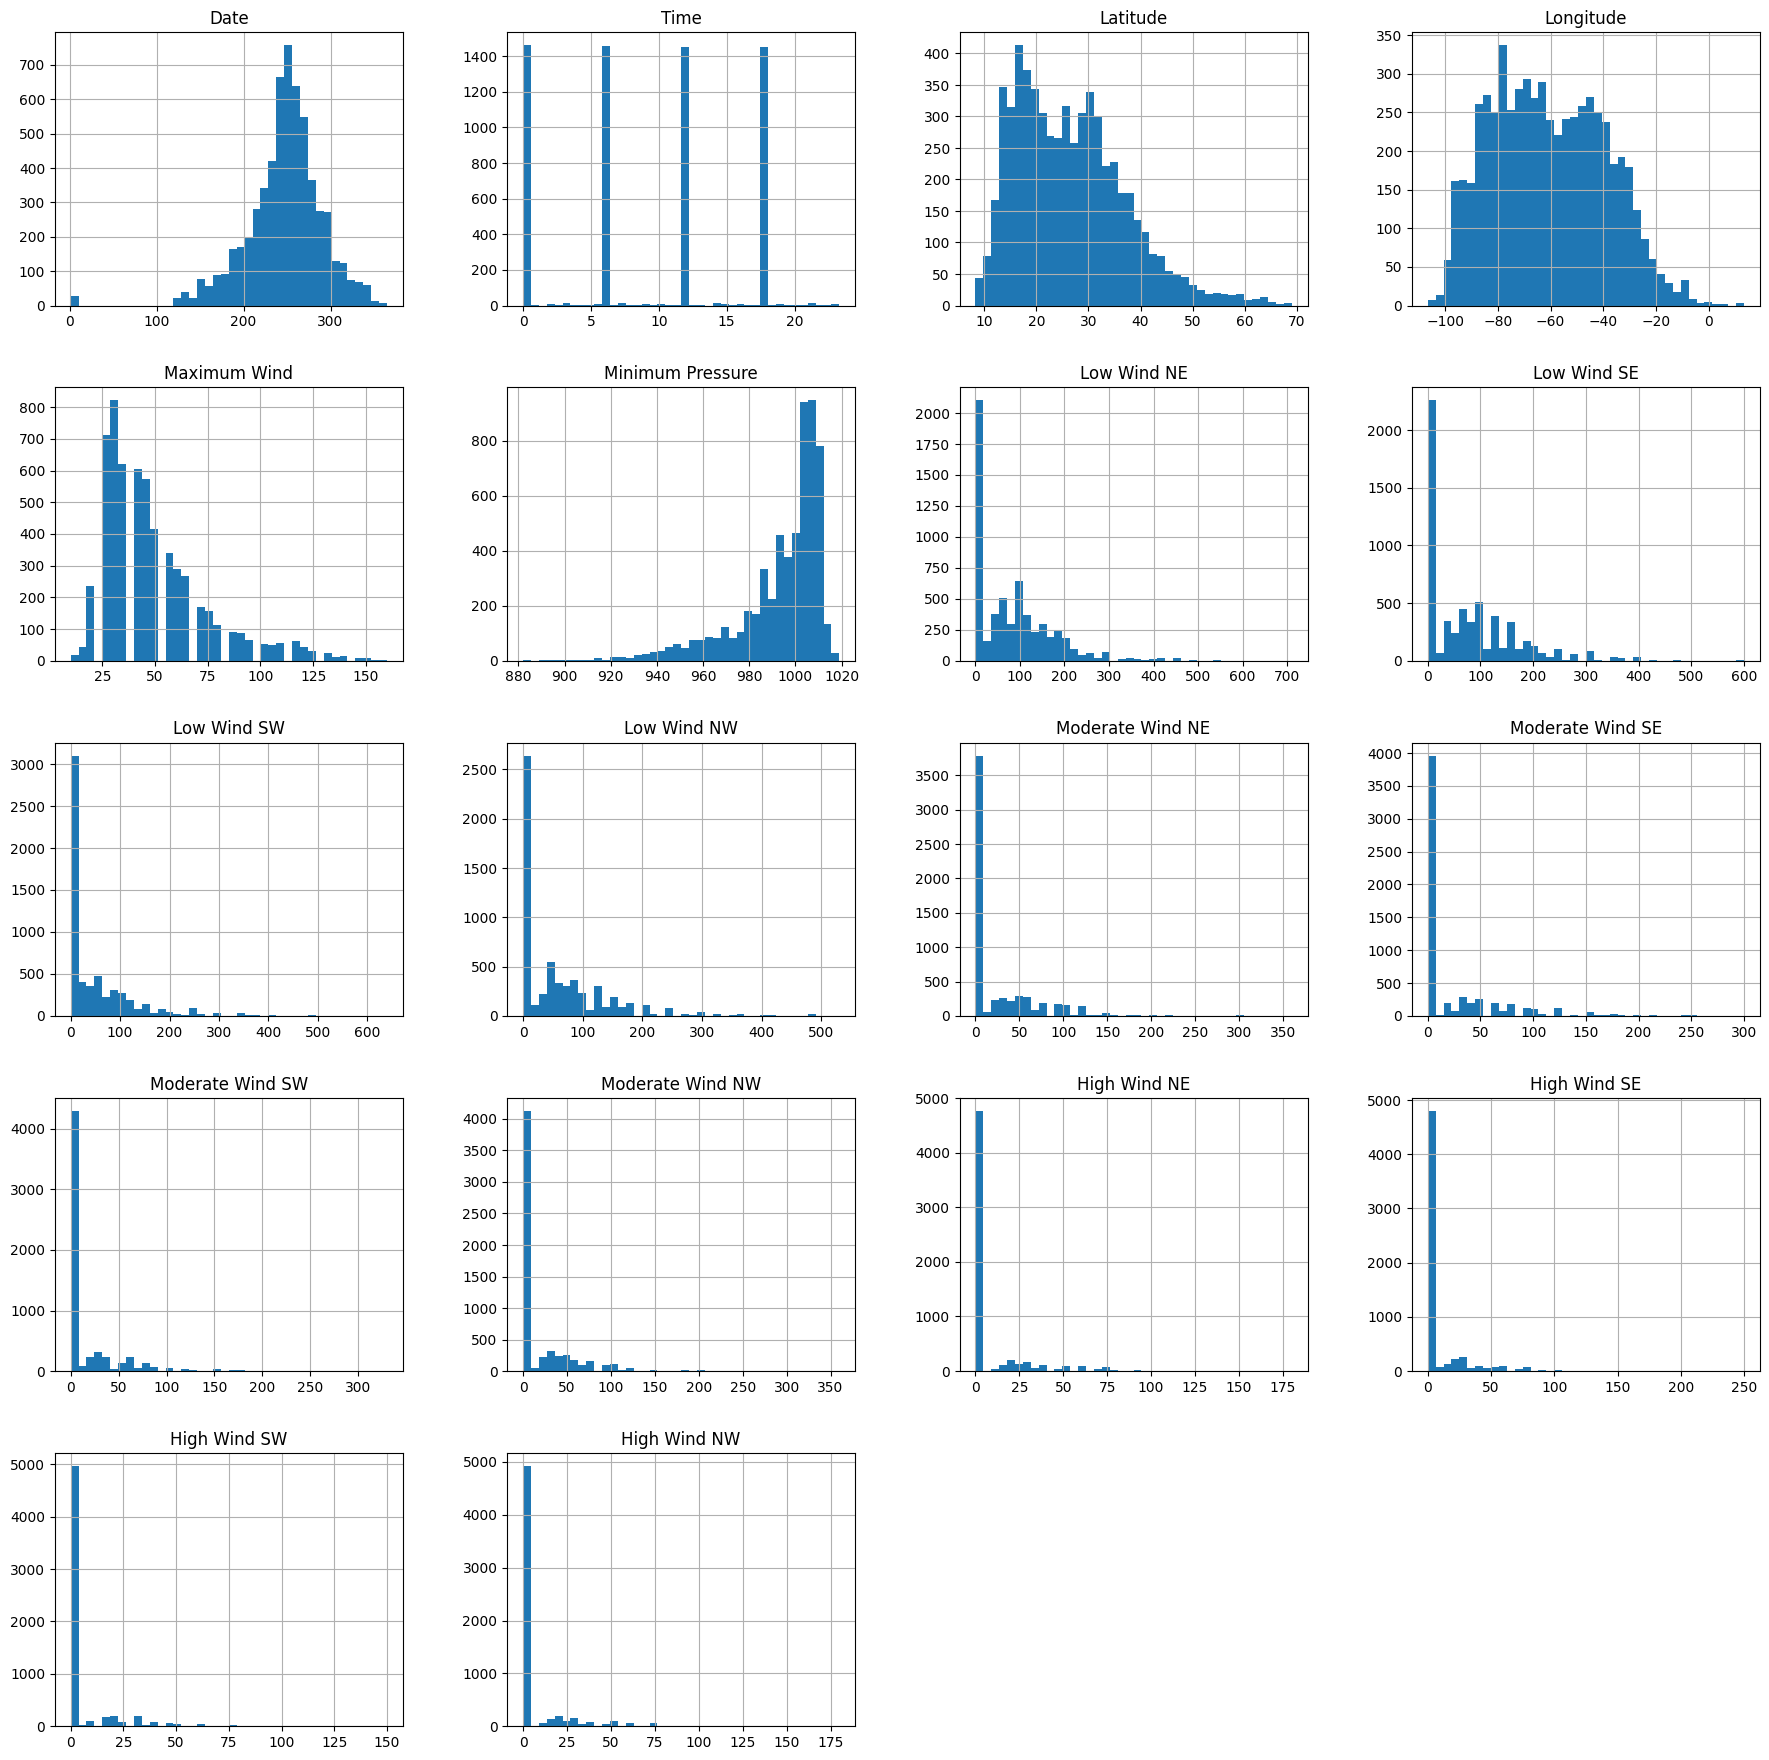

In [171]:
PD_n.hist(bins=40, figsize=(22,22))
plt.show()

##### Inspect the statistics of each numeric column
As can be seen from descriptive statistics there are 5999 rows/data points. Please note that this data points were irrespective of unique hericane ID or name.

In [172]:
PD_n.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Date,5999.0,247.269045,43.420434,1.0,227.000,251.0,272.000,365.0
Time,5999.0,9.067645,6.722907,0.0,5.275,10.3,16.225,23.3
Latitude,5999.0,26.573429,10.594913,8.3,18.000,25.4,32.950,69.0
Longitude,5999.0,-60.810852,21.433261,-106.7,-78.300,-62.4,-44.200,13.5
Maximum Wind,5999.0,48.607268,24.873601,10.0,30.000,40.0,60.000,160.0
Minimum Pressure,5999.0,993.619103,19.153452,882.0,987.000,1000.0,1007.000,1019.0
Low Wind NE,5999.0,81.888298,87.666057,0.0,0.000,60.0,130.000,710.0
Low Wind SE,5999.0,76.454528,87.136117,0.0,0.000,60.0,120.000,600.0
Low Wind SW,5999.0,48.558367,74.831107,0.0,0.000,0.0,75.000,640.0
Low Wind NW,5999.0,59.086555,77.168592,0.0,0.000,40.0,90.000,530.0


### Normalization (Optional and not implemented)
This is an optional phase. As I am using Latitude and longitude as feature plus label, normalizing this value will affect the semantic meaning/validity of the attribute that, this step is skipped.
The implementation is provided in the function "prepare_samples" below that if needed, can turn the parameter normalize into True

### Convert dataframe to an array wich is suitable for LSTM
As the problem is coined as multivariate sequence to sequence prediction, The data is prepared as follows. Time series observation for each unique herican is converted into a 3-dimensional numpy array of [B,T, A] where B is number of batchs, T is sequence length(time window) to model subsequent event which is 4 and A is number of attributes which is 18.

In train test split and sampling, the following purposive customization is done. When the data is segregated, the number of rows allocated for trainning were not sufficient that, I simply randomly select testing hericanes. As validation samples are only used to track the learning process, I train without validation samples. This all is to use many data points for model training.

But the code used for sampling, generation of trainingand testing samples are commented and can be used when sufficient data is available or if one decided to work on only hericane coordinates.

Deasign:
    Features: all observations within previous time t units(24 hours)
    Label: latitude and longitue at t+1 units
    As indicated in figure below, column A contains all the attributes at time window t while Lat and long are modeeled as labels
    
   ![image-5.png](attachment:image-5.png)

In [173]:
def sampler(pdf, train_test_ratio = [0.7, 0.15, 0.15], strategy='pick', number_test=3):

    '''
    The function takes full datframe and undertakes sample partitioning
    pdf: is the dataframe that contains all hericane trajectories
    train_test_ratio: the ratio used for training, validation and testing respectively
    strategy: how sample is alloted, either using provided ratios or just user defined number
    number_test: if strategy is "pick" the number of test samples reserved for testing
    returns: list of unique hurricane IDs allocatied for trainning, vaidation and testing
    '''

    inds = list(np.unique(pdf['ID']))  # take uniqe hericane IDS

    random.seed(2)   # for reproduciability
    random.shuffle(inds) # shuffle

    if strategy == 'pick':
        test_ids = random.sample(inds, number_test)
        train_ids = list(set(inds).symmetric_difference(set(test_ids)))
        return train_ids, test_ids
    else:

        N = len(inds)

        trn = round(N*train_test_ratio[0])
        vln = round(N*train_test_ratio[1])
        tsn = round(N*train_test_ratio[2])

        train = inds[:trn]         # training hericanes
        valid = inds[trn:trn+vln]  # validation hericanes
        test = inds[trn+vln:]      # test hericanes

        return train, valid, test

In [174]:
def prepare_samples(pdf, hid, remove_cols=['ID', 'Event', 'Status', 'Name'], w=3, normalize=False):
    '''
    Prepares samples by taking specific hurricane ID
    pdf: dataframe containing all attributes and labels
    hid: unique hurricane ID
    remove_cols: list of column/attribute names not included in the analysis
    W: window length to segment time sereis data
    normalize: boolean value whether toundertaken data normalization. If True, undrtakes minmax-normalization
    returns: prepared features with shape [B, T, A] and labels with shape [B, L], where L is number of sequence length to predict
    '''

    samp = pdf[pdf['ID']==hid]  # subset specific hericane

    if remove_cols is not None:
        feat_negin = samp.drop(remove_cols, axis=1)
    else:
        feat_negin = samp
#     feat = feat_negin.drop(['Latitude', 'Longitude'],  axis=1)
    feat = feat_negin

    if normalize:
        min_max_scaler = preprocessing.MinMaxScaler()
        scaled = min_max_scaler.fit_transform(feat.values)
        col_names = list(feat.keys())
        feat = pd.DataFrame(scaled, columns=col_names)

    label = feat_negin[['Latitude', 'Longitude']]

    c = feat.shape[0]
    if c<=w:
        print('Hericane with ID: {} -> has length less than window and not included in the features'.format(hid))
        return None, None
    else:
        feature_map = []
        label_map = []

        for i in range(c-w-1):
            FF = np.array(feat.iloc[i:i+w])
            LL = label.iloc[i+w+1]
            feature_map.append(FF)
            label_map.append(LL)

        feature_map = np.array(feature_map)
        label_map = np.array(label_map)

        # # for more caution
#         if len(feature_map.shape) == 2:
#             feature_map = np.expand_dims(feature_map, axis=0)
#         if len(label_map.shape) == 2:
#             label_map = np.expand_dims(label_map, axis=0)

        return feature_map, label_map

In [175]:
def prepare_features(IDS, pdfs, w=3):
    '''
    Undertakes batch processing for all hurricanes
    IDS: list of unique Hurricane IDs
    pdfs: data frame containing all features and labels columns
    w: window length to segment time series into datapoints suitable for LSTM input
    '''

    features = []
    labels = []

    for ids in IDS:
        data = prepare_samples(pdf=pdfs, hid=ids, w=w)

        if data[0] is None or data[1] is None:
            pass
        else:
            if data[0].shape == 2 or data[1].shape == 2:
                data[0] = np.expand_dimes(data[0], axis=0)
                data[1] = np.expand_dimes(data[1], axis=0)
                features.append(data[0])
                labels.append(data[1])
            else:
                features.append(data[0])
                labels.append(data[1])

    inds = [i for i in range(len(features)) if len(features[i].shape)==3]
    features = [features[j] for j in inds]
    labels = [labels[j] for j in inds]

    features = np.concatenate(tuple(features), axis=0)
    labels = np.concatenate(tuple(labels), axis=0)

    return features, labels

#### Select training and test hericanes before data preparation.
This is mainly bacause, the test data should be inspected independently using its unique hericane ID later on after trainning

In [176]:
test_sample_intake = 'pick'
if test_sample_intake == 'pick':
    samples = sampler(PD_n)
    train_ids = samples[0]
    test_ids = samples[1]
    print('Length of training herican samples: {}'.format(len(train_ids)))
    print('Length of test herican samples: {}'.format(len(test_ids)))
else:
    samples = sampler(PD_n, strategy='ratio')
    train_ids = samples[0]
    validation_ids = samples[1]
    test_ids = samples[2]
    print('Length of training herican samples: {}'.format(len(train_ids)))
    print('Length of validation herican samples: {}'.format(len(validation_ids)))
    print('Length of test herican samples: {}'.format(len(test_ids)))

Length of training herican samples: 195
Length of test herican samples: 3


###### Please note that as indicated below if there is herican event with observations less than or equal to proposed sequence length to model, it is excluded from being part of analysis

In [177]:
# Prepare trainning features
train_samples = prepare_features(IDS=train_ids, pdfs=PD_n, w=3)
train_feature = train_samples[0]
train_label = train_samples[1]
print('Shape of training features', train_feature.shape)
print('Shape of trainning labels',  train_label.shape)

Shape of training features (5056, 3, 18)
Shape of trainning labels (5056, 2)


##### Note
the following commented cells are used if we have sufficient amount of samples to partition

In [ ]:
# Prepare validation samples
# validation_samples = prepare_features(IDS=validation_ids, pdfs=PD_n)
# validation_feature = validation_samples[0]
# validation_label = validation_samples[1]
# validation_feature.shape, validation_label.shape

In [ ]:
# prepare test samples
# test_samples = prepare_features(IDS=test_ids, pdfs=PD_n)
# test_feature = validation_samples[0]
# test_label = validation_samples[1]
# test_feature.shape, test_label.shape

In [ ]:
# combine, shuffle and sample again
# features = np.concatenate((train_feature,validation_feature, test_feature), axis=0)
# labels  = np.concatenate((train_label,validation_label, test_label), axis=0)
# features.shape, labels.shape

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.05, random_state=42)
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

### Model design and training

In [178]:
# optimizers to use give a try and select one. In principle this should be done in a
# grid-search strategy but I have tried it with one by one basis
sgd = SGD(learning_rate=0.001, momentum=0.9)
adm = Adam(learning_rate=0.001)
msprop = RMSprop(learning_rate=0.0001,rho=0.9, momentum=0.9, centered=True)

In [179]:
tf.keras.backend.clear_session()
data_shape = (train_feature.shape[1], train_feature.shape[-1])
model = Sequential()
model.add(Bidirectional(LSTM(500,return_sequences=True), input_shape=data_shape))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(500)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64)) # relu
model.add(Dropout(0.2))   #
model.add(Dense(2)) # out_size
model.compile(loss='mse', optimizer=msprop)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 3, 1000)             │       2,076,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 3, 1000)             │           4,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 1000)                │       6,004,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1000)                │           4,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          64,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,152,194 (31.10 MB)

 Trainable params: 8,148,194 (31.08 MB)

 Non-trainable params: 4,000 (15.62 KB)

#### fit the model to the data

In [151]:
hist = model.fit(x=train_feature,
                 y=train_label,
                 epochs=50,
                 verbose=1)

Epoch 1/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 58s 353ms/step - loss: 57.5851
Epoch 2/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 58s 365ms/step - loss: 52.1857
Epoch 3/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 79s 348ms/step - loss: 47.1820
Epoch 4/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 89s 397ms/step - loss: 46.4894
Epoch 5/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 73s 342ms/step - loss: 48.6528
Epoch 6/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 77s 309ms/step - loss: 43.6072
Epoch 7/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 85s 327ms/step - loss: 41.4846
Epoch 8/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 80s 316ms/step - loss: 42.5104
Epoch 9/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 49s 313ms/step - loss: 41.4390
Epoch 10/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 82s 313ms/step - loss: 40.4226
Epoch 11/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 82s 311ms/step - loss: 38.1021
Epoch 12/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 86s 339ms/step - loss: 41.7129
Epoch 13/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 78s 314ms/step - loss: 38.4317
Epoch 14/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 50s 313ms/step - loss: 35.2806
E

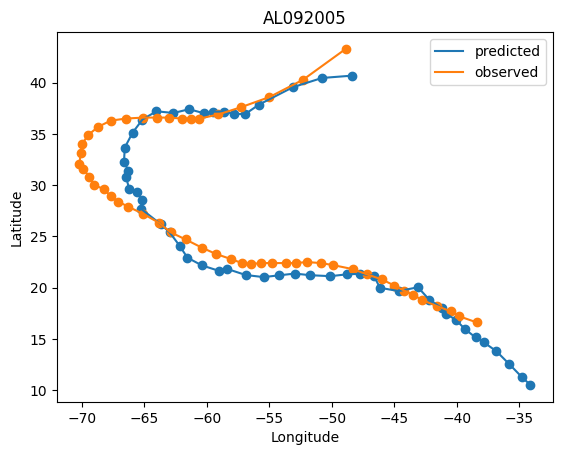

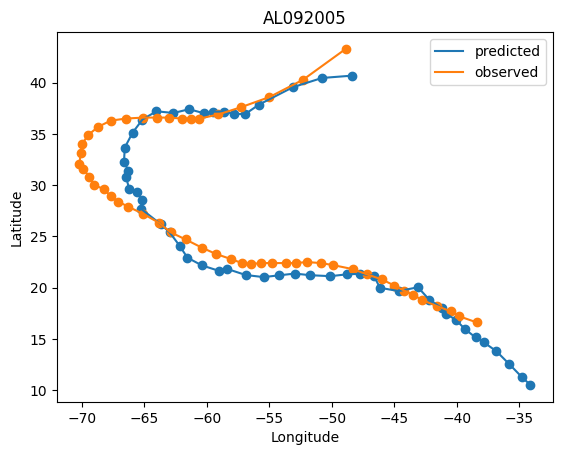

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


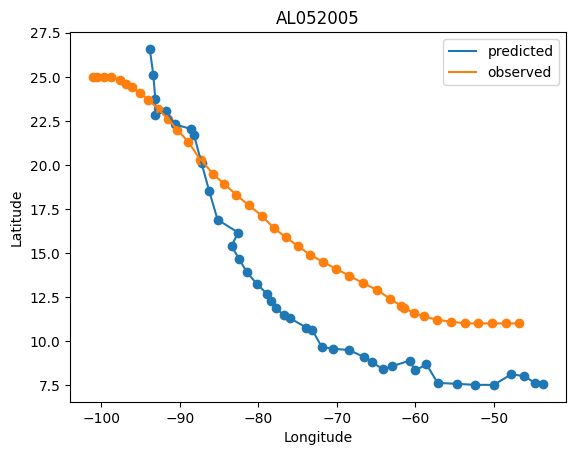

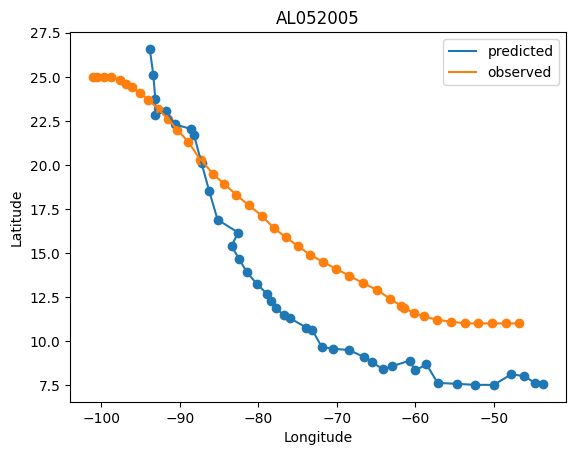

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


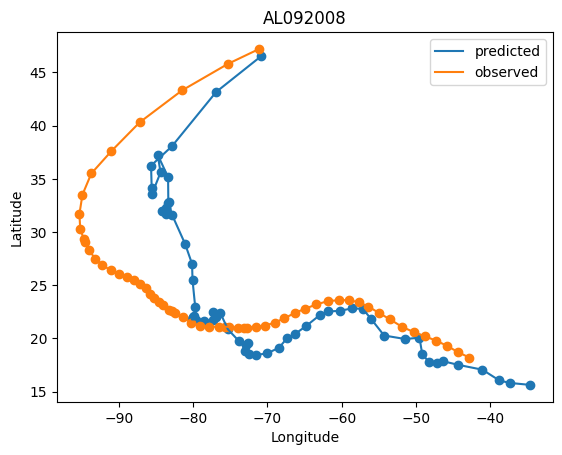

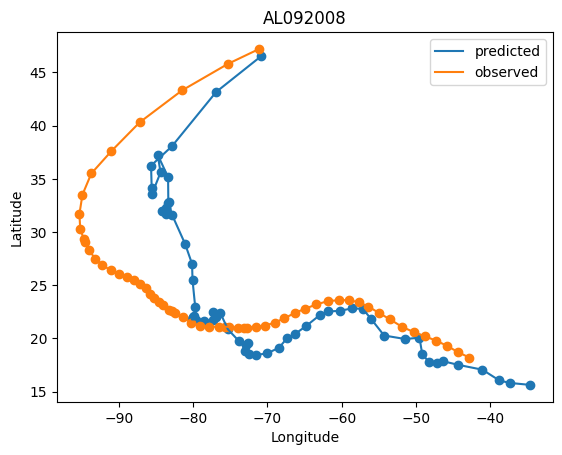

In [152]:
# compute metrics and plot predicted and reference hericane trajectories
MSE = tf.keras.metrics.MeanSquaredError()   # mean squared error
MAE = tf.keras.metrics.MeanAbsoluteError()   # mean absolute error

mse = []
mae = []

for i in range(len(test_ids)):
    one_id = test_ids[i]
    tr_f = prepare_samples(pdf=PD_n, hid=one_id, w=3)  # prepare test data and ingest into trained model
    pred = hist.model.predict(tr_f[0])

    MSE.update_state(tf.constant(tr_f[1]), pred)  # compute accuracy per test herican ID usimg predicted and refenrece data
    mse.append(MSE.result().numpy()) # append it
    # MSE.reset_states()

    MAE.update_state(tf.constant(tr_f[1]), pred)  # compute accuracy per test herican ID usimg predicted and refenrece data
    mae.append(MAE.result().numpy()) # append it
    # MAE.reset_states()

    plt.scatter(pred[:,1], pred[:,0])
    plt.plot(pred[:,1], pred[:,0], label='predicted')
    plt.scatter(tr_f[1][:,1], tr_f[1][:,0])
    plt.plot(tr_f[1][:,1], tr_f[1][:,0], label='observed')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(one_id)
    plt.legend()
    plt.show()

In [195]:
# check the mean squared error
print('Herican ID -> Mean Absolute Error  -> Mean Squred Error')
for i in range(len(test_ids)):
    print('{} -> {}  -> {}'.format(test_ids[i], mae[i], mse[i]))

Herican ID -> Mean Absolute Error  -> Mean Squred Error
AL092005 -> 43.09075164794922  -> 2151.96142578125
AL052005 -> 44.94786071777344  -> 2648.0732421875
AL092008 -> 47.04563903808594  -> 2897.626953125


In [192]:
# Save the trained model
# name = 'best_trajectory_model_weight.h5'
# if 'trained_model_weights' not in os.listdir(data_folder): # create model weight directory
#     model_path = os.path.join(data_folder, 'trained_model_weights')
#     os.makedirs(model_path, exist_ok=True)
#     model_name = os.path.join(model_path, name)
# else:
# model_path = os.path.join(data_folder, 'trained_model_weights')
model_name = '/content/drive/MyDrive/plus-deepdata-social-good-master/trained_model_weights/weights.ckpt' # os.path.join(model_path, name)
model.save_weights('.weights.h5') # save model weights

In [188]:
os.getcwd()

'/content'

#### Optional
If need to load save weights first define the same model

In [189]:
tf.keras.backend.clear_session()
data_shape = (train_feature.shape[1], train_feature.shape[-1])
new_model = Sequential()
new_model.add(Bidirectional(LSTM(500,return_sequences=True), input_shape=data_shape))
new_model.add(BatchNormalization())
new_model.add(Bidirectional(LSTM(500)))
new_model.add(BatchNormalization())
new_model.add(Dropout(0.2))
new_model.add(Dense(64)) # relu
new_model.add(Dropout(0.2))   #
new_model.add(Dense(2)) # out_size
new_model.compile(loss='mse', optimizer=msprop)

In [193]:
# weight_fold = os.path.join(data_folder, 'trained_model_weights')
weights_path = '/content/drive/MyDrive/plus-deepdata-social-good-master/trained_model_weights/best_trajectory_model_weight.h5' # os.path.join(weight_fold, name) # name is the weight name used to save the trained weight
if weights_path is not None:
    new_model.load_weights('.weights.h5')
    print('model weights loaded from {}'.format(weights_path))

model weights loaded from /content/drive/MyDrive/plus-deepdata-social-good-master/trained_model_weights/best_trajectory_model_weight.h5


In [196]:
# # compute metrics and plot predicted and reference hericane trajectories
# MSE = tf.keras.metrics.MeanSquaredError()   # mean squared error
# MAE = tf.keras.metrics.MeanAbsoluteError()   # mean absolute error

# mse = []
# mae = []

# for i in range(len(test_ids)):
#     one_id = test_ids[i]
#     tr_f = prepare_samples(pdf=PD_n, hid=one_id, w=3)  # prepare test data and ingest into trained model
#     pred = model.predict(tr_f[0])

#     MSE.update_state(tf.constant(tr_f[1]), pred)  # compute accuracy per test herican ID usimg predicted and refenrece data
#     mse.append(MSE.result().numpy()) # append it
#     # MSE.reset_states()

#     MAE.update_state(tf.constant(tr_f[1]), pred)  # compute accuracy per test herican ID usimg predicted and refenrece data
#     mae.append(MAE.result().numpy()) # append it
#     # MAE.reset_states()

#     plt.scatter(pred[:,1], pred[:,0])
#     plt.plot(pred[:,1], pred[:,0], label='predicted')
#     plt.scatter(tr_f[1][:,1], tr_f[1][:,0])
#     plt.plot(tr_f[1][:,1], tr_f[1][:,0], label='observed')
#     plt.xlabel('Longitude')
#     plt.ylabel('Latitude')
#     plt.title(one_id)
#     plt.legend()
#     plt.show()